<a href="https://colab.research.google.com/github/yanamushka/ML-course/blob/main/HW_2_4_kNN_%D0%9A%D1%80%D0%BE%D1%81%D0%B2%D0%B0%D0%BB%D1%96%D0%B4%D0%B0%D1%86%D1%96%D1%8F_%D1%96_%D1%82%D1%8E%D0%BD%D0%B8%D0%BD%D0%B3_%D0%B3%D1%96%D0%BF%D0%B5%D1%80%D0%BF%D0%B0%D1%80%D0%B0%D0%BC%D0%B5%D1%82%D1%80%D1%96%D0%B2_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

В цьому домашньому завданні ми знову працюємо з даними з нашого змагання ["Bank Customer Churn Prediction (DLU Course)"](https://www.kaggle.com/t/7c080c5d8ec64364a93cf4e8f880b6a0).

Тут ми побудуємо рішення задачі класифікації з використанням kNearestNeighboors, знайдемо оптимальні гіперпараметри для цього методу і зробимо базові ансамблі. Це дасть змогу порівняти перформанс моделі з попередніми вивченими методами.

0. Зчитайте дані `train.csv` та зробіть препроцесинг використовуючи написаний Вами скрипт `process_bank_churn.py` так, аби в результаті отримати дані в розбитті X_train, train_targets, X_val, val_targets для експериментів.

  Якщо Вам не вдалось реалізувати в завданні `2.3. Дерева прийняття рішень` скрипт `process_bank_churn.py` - можна скористатись готовим скриптом з запропонованого рішення того завдання.

In [ ]:
import pandas as pd
import numpy as np
from process_bank_churn import process_data

In [ ]:
data = pd.read_csv('train.csv')

In [ ]:
preprocessed_data = process_data(data, target_col = 'Exited', drop_cols=['Surname', 'id', 'CustomerId'])

In [ ]:
X_train = preprocessed_data['X_train']
train_targets = preprocessed_data['train_targets']
X_val = preprocessed_data['X_val']
val_targets = preprocessed_data['val_targets']

In [ ]:
X_train.drop(columns=['Geography', 'Gender'], inplace=True)
X_val.drop(columns=['Geography', 'Gender'], inplace=True)

1. Навчіть на цих даних класифікатор kNN з параметрами за замовченням і виміряйте точність з допомогою AUROC на тренувальному та валідаційному наборах. Зробіть заключення про отриману модель: вона хороша/погана, чи є high bias/high variance?

In [ ]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import roc_auc_score

In [ ]:
knn = KNeighborsClassifier()
knn.fit(X_train, train_targets)
#

KNeighborsClassifier()

In [ ]:
y_train = knn.predict(X_train)
y_val = knn.predict(X_val)

In [ ]:
roc_auc_score(train_targets, y_train), roc_auc_score(val_targets, y_val)

(0.8071455848505019, 0.7470789761311686)

Бачимо що на тестовому наборі даних модель показує доволі не поганий результат значення AUROC 0.8, проте на нових валідаційних даних показник трохи гірший і уже 0.74. Така різниця в показниках може свідчити про high variance, тому можливо має сенс змінити значення показника k і оцінити результати передбачень.

2. Використовуючи `GridSearchCV` знайдіть оптимальне значення параметра `n_neighbors` для класифікатора `kNN`. Псотавте крос валідацію на 5 фолдів.

  Після успішного завершення пошуку оптимального гіперпараметра
    - виведіть найкраще значення параметра
    - збережіть в окрему змінну `knn_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `knn_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи стала вона краще порівняно з попереднім пукнтом (2) цього завдання? Чи є вона краще за дерево прийняття рішень з попереднього ДЗ?

In [ ]:
from sklearn.model_selection import GridSearchCV

In [ ]:
?GridSearchCV

In [ ]:
params = {'n_neighbors': np.arange(1, 10)}
knn_gs = GridSearchCV(knn, params, cv = 5)
knn_gs.fit(X_train, train_targets)

GridSearchCV(cv=5, estimator=KNeighborsClassifier(),
             param_grid={'n_neighbors': array([1, 2, 3, 4, 5, 6, 7, 8, 9])})

In [ ]:
knn_best = knn_gs.best_estimator_

In [ ]:
y_pred_test_best = knn_best.predict(X_train)
y_pred_val_best = knn_best.predict(X_val)

In [ ]:
roc_auc_score(train_targets, y_pred_test_best), roc_auc_score(val_targets, y_pred_val_best)

(0.793481451514887, 0.7476239326289851)

Бачимо, що модель має нижчий показник на тренувальному наборі даних, проте результат для валідаційного набору майже не змінився, що означає що різниця якості передбачень для тренувального і валідаційного наборів зменшилась як і перенавчання моделі. Для дерева прийняття рішень результат на тренувальному наборі  становив 1.0, а на валідаційному 0.756. Тобто модель дерева прийняття рішень має вищий результат на валідаційному наборі даних.

3. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `GridSearchCV` за сіткою параметрів
  - `max_depth` від 1 до 20 з кроком 2
  - `max_leaf_nodes` від 2 до 10 з кроком 1

  Обовʼязково при цьому ініціюйте модель з фіксацією `random_state`.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_best` найкращу модель, знайдену з `GridSearchCV`
    - оцініть якість передбачень  `dt_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли вручну?

In [79]:
from sklearn.tree import DecisionTreeClassifier
from time import time as timestamp

In [51]:
tree = DecisionTreeClassifier(random_state=42)

In [ ]:
params_tree = {'max_depth': np.arange(1, 20, 2), 'max_leaf_nodes': np.arange(2, 10, 1)}

In [70]:
start = timestamp()
tree_best = GridSearchCV(tree, params_tree, cv = 3, scoring='roc_auc')
tree_best.fit(X_train, train_targets)
end = timestamp()
print(f'Час пошуку оптимальних гіперпараметрів: {end - start} секунд')
dt_best = tree_best.best_estimator_


Час пошуку оптимальних гіперпараметрів: 4.40998911857605 секунд


In [72]:
y_train_df = dt_best.predict(X_train)
y_val_df = dt_best.predict(X_val)

In [73]:
roc_auc_score(train_targets, y_train_df), roc_auc_score(val_targets, y_val_df)

(0.7592332903774226, 0.748981058593354)

За резульататом бачимо, що модель знайдена вручну має все ще вищий показник на валідаційному наборі (0.756>0.748), тому вона краща. Хоча дана модель не має перенавчання.

4. Виконайте пошук оптимальних гіперпараметрів для `DecisionTreeClassifier` з `RandomizedSearchCV` за заданою сіткою параметрів і кількість ітерацій 40.

  Поставте кросвалідацію на 3 фолди, `scoring='roc_auc'`, зафіксуйте `random_seed` процедури крос валідації та виміряйте, скільки часу потребує пошук оптимальних гіперпараметрів.

  Після успішного завершення пошуку оптимальних гіперпараметрів
    - виведіть найкращі значення параметра
    - збережіть в окрему змінну `dt_random_search_best` найкращу модель, знайдену з `RandomizedSearchCV`
    - оцініть якість передбачень  `dt_random_search_best` на тренувальній і валідаційній вибірці з допомогою AUROC.
    - зробіть висновок про якість моделі. Чи ця модель краща за ту, що ви знайшли з `GridSearch`?
    - проаналізуйте параметри `dt_random_search_best` і порівняйте з параметрами `dt_best` - яку бачите відмінність? Ця вправа потрібна аби зрозуміти, як різні налаштування `DecisionTreeClassifier` впливають на якість моделі.

In [58]:
params_dt = {
    'criterion': ['gini', 'entropy'],
    'splitter': ['best', 'random'],
    'max_depth': np.arange(1, 20),
    'max_leaf_nodes': np.arange(2, 20),
    'min_samples_split': [2, 5, 10, 20],
    'min_samples_leaf': [1, 2, 4, 8],
    'max_features': [None, 'sqrt', 'log2']
}

In [59]:
from sklearn.model_selection import RandomizedSearchCV

In [81]:
start = timestamp()
tree_best_2 = RandomizedSearchCV(tree, params_dt, n_iter = 40,  cv = 3, scoring = 'roc_auc', random_state=42)
tree_best_2.fit(X_train, train_targets)
end = timestamp()
print(f'Час пошуку оптимальних гіперпараметрів: {end - start} секунд')
dt_random_search_best = tree_best_2.best_estimator_


Час пошуку оптимальних гіперпараметрів: 1.4486768245697021 секунд


In [82]:
y_pred_random_search_test = dt_random_search_best.predict(X_train)
y_pred_random_search_val = dt_random_search_best.predict(X_val)

In [83]:
roc_auc_score(train_targets, y_pred_random_search_test), roc_auc_score(val_targets, y_pred_random_search_val)

(0.8002717615857736, 0.7951123720482072)

Бачимо, що дана модель краща за модель з параметрами знайденими з GridSearch. Показник AUROC  вищий для тренувального та валідаційного набору даних.

In [84]:
dt_random_search_best

DecisionTreeClassifier(criterion='entropy', max_depth=16, max_leaf_nodes=14,
                       min_samples_leaf=2, min_samples_split=20,
                       random_state=42)

In [85]:
dt_best

DecisionTreeClassifier(max_depth=5, max_leaf_nodes=9, random_state=42)

Бачимо dt_random_search_best використовує критерій ʼентропіяʼ замість встановленого за замовчуванням 'gini', також максимальна глибина дерева - 16 в той час як в оптимальної моделі за GridSearchCV максимальна глибина 5. Щоб уникнути перенавчання в dt_random_search_best обмежуються максимальна кількість вузлів до 14 та розмір мінімальної вибірки для розчеплення становить 20.

5. Якщо у Вас вийшла метрика `AUROC` в цій серії експериментів - зробіть ще один `submission` на Kaggle і додайте код для цього і скріншот скора на публічному лідерборді нижче.

  Сподіваюсь на цьому етапі ви вже відчули себе справжнім дослідником 😉

In [92]:
test = pd.read_csv('test.csv')
test.drop(columns=['Surname', 'id', 'CustomerId'], inplace=True)

In [94]:
test_preprocessed = process_data(test, target_col = None)

In [98]:
x_test = test_preprocessed['processed_data'].drop(columns = ['Geography', 'Gender'])

In [100]:
x_test

,CreditScore,Age,Tenure,Balance,NumOfProducts,HasCrCard,IsActiveMember,EstimatedSalary,Geography_France,Geography_Germany,Geography_Spain,Gender_Female,Gender_Male
0,0.365155,0.214286,0.181818,0.781918,0.000000,1.0,1.0,0.025851,0.0,1.0,0.0,0.0,1.0
1,0.286396,0.375000,0.454545,0.000000,0.333333,1.0,1.0,0.010998,1.0,0.0,0.0,0.0,1.0
2,0.656325,0.446429,0.727273,0.000000,0.333333,1.0,0.0,0.025666,1.0,0.0,0.0,0.0,1.0
3,0.682578,0.482143,0.272727,0.000000,0.000000,1.0,1.0,0.027332,0.0,0.0,1.0,0.0,1.0
4,0.384248,0.446429,0.727273,0.000000,0.333333,1.0,1.0,0.023518,0.0,0.0,1.0,0.0,1.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
9995,0.496420,0.357143,0.909091,0.000000,0.333333,1.0,1.0,0.008077,0.0,0.0,1.0,0.0,1.0
9996,0.589499,0.375000,0.818182,0.000000,0.333333,1.0,1.0,0.023326,0.0,0.0,1.0,0.0,1.0
9997,0.818616,0.214286,0.818182,0.000000,0.333333,1.0,0.0,0.000725,1.0,0.0,0.0,0.0,1.0
9998,0.391408,0.357143,0.545455,0.775612,0.000000,1.0,0.0,0.020692,1.0,0.0,0.0,0.0,1.0


In [87]:
submit_csv = pd.read_csv('sample_submission.csv')

In [108]:
submit_csv['Exited'] = dt_random_search_best.predict_proba(x_test)[:,1]

In [111]:
submit_csv.to_csv('submission_tree_tuned_param.csv', index = False)

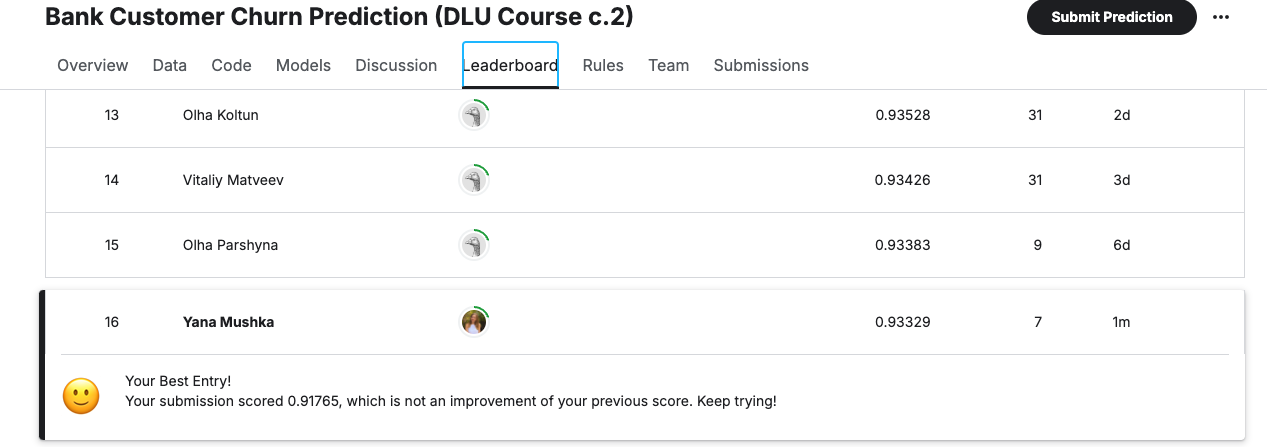